<a href="https://colab.research.google.com/github/Vidushi-GitHub/NASA_GCN_NLP/blob/main/Test_Topic_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Topic Modelling Pipeline for the NASA GCN Platform**
The aim of this project is to leverage the power of BERTopic to build a transformer powered topic model for the NASA GCN circular database.

It is recommended to run this notebook in Google Colab. Please not that before running this notebook you will need to set up a free HuggingFace account and create an access token to pull down models from Huggingface. More info can be found here: https://huggingface.co/docs/hub/en/security-tokens. Store your token in Google Colab's Secrets as HF_LOGIN_TOKEN and turn on notebook access. More info found here: https://drlee.io/how-to-use-secrets-in-google-colab-for-api-key-protection-a-guide-for-openai-huggingface-and-c1ec9e1277e0.

To get results consistent with those reported in the paper, it is recommended to run each section in this notebook sequentially and only once. Re-running it without restarting the runtime may yield slightly different results in certain sections due to the inherently stochastic nature of some of the agorithms used. We also recommend using Google Colab's L4 GPU runtime, which is what we used in our work. This is not a requirement and any GPU runtime may suffice, however using a different runtime may once again produce minor deviations from the results in our paper, as variations in hardware configurations can affect the outcomes of some of the algorithms used. Using the L4 GPU, however, may require the purchase of a temporary subscription to Colab Pro for $10.

#STEP 1: Install necessary libraries

In [1]:
!wget https://github.com/ronitagarwala01/NASA_GCN_NLP/raw/main/data/archive.json.tar.gz -O /content/archive.json.tar.gz
#!wget https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/custom_stopwords.txt -O /content/custom_stopwords.txt

--2025-02-01 23:24:38--  https://github.com/ronitagarwala01/NASA_GCN_NLP/raw/main/data/archive.json.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive.json.tar.gz [following]
--2025-02-01 23:24:38--  https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/archive.json.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25855098 (25M) [application/octet-stream]
Saving to: ‘/content/archive.json.tar.gz’

/content/archive.js 100%[===================>]  24.66M   131MB/s    in 0.2s    

2025-02-01 23:24:39 (131 MB/s) - ‘/content/a

In [2]:
%pip install bertopic==0.16.2 -qqq
%pip install huggingface_hub==0.25.2 -qqq
%pip install safetensors==0.4.3 -qqq
%pip install accelerate==0.30.1 -qqq
%pip install sentence-transformers==2.2.2 -qqq
%pip install peft==0.7.1 -qqq
%pip install -U plotly==5.19.0 -qqq
#!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python==0.2.76 -qqq
#!wget https://huggingface.co/TheBloke/Mistral-7B-Instruct-v0.2-GGUF/resolve/main/mistral-7b-instruct-v0.2.Q4_K_M.gguf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/

#Step 2: Import Libraries

In [3]:
import tarfile
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from wordcloud import WordCloud
#import nltk
#from nltk.corpus import stopwords
#import string
#import re
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
import torch
import accelerate
from torch import Tensor
from transformers import AutoTokenizer, AutoModel, pipeline
from tqdm import tqdm
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.manifold import TSNE
import plotly.graph_objects as go
import plotly.express as px
import itertools
import pandas as pd
#from llama_cpp import Llama
#from bertopic.representation import LlamaCPP
from bertopic.representation import BaseRepresentation
from bertopic.backend import BaseEmbedder
from datetime import datetime
import matplotlib.dates as mdates
from sentence_transformers.readers import InputExample
from sentence_transformers import SentencesDataset, losses
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import time
# from huggingface_hub import login
# from google.colab import userdata
import random

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

# Huggingface login required to use Mistral 7B Instruct
# Make sure to save your own Huggingface login token in your Notebook's Secrets as 'HF_LOGIN_TOKEN'
# login_token = userdata.get('GCN-Test')
# login(token=login_token)

#nltk.download('stopwords') #NLTK package for stopwords list

#Step 3: Extract GCN Circulars

In [4]:
'''
Extract circular JSONs from tar file.
'''

with tarfile.open('./archive.json.tar.gz', 'r') as file:
  file.extractall(path='./all_gcn_circulars')

dir = os.listdir('./all_gcn_circulars/archive.json') #Store all file names as strings in dir

#Add file path to beginning of file names in dir
dir = ['./all_gcn_circulars/archive.json/' + filename for filename in sorted(dir)]

print(f'Number of Circular JSONs: {len(dir)}\n')
print(f'First JSON path is: {dir[0]}')

Number of Circular JSONs: 38919

First JSON path is: ./all_gcn_circulars/archive.json/-1.json


In [5]:
'''
Extract circular bodies from JSON list.
'''

circulars = []
circular_bodies = []
time_stamps = []
for file in dir:
  with open(file, encoding='utf-8') as f:
    data = json.load(f)
    circulars.append(data)
    circular_bodies.append(data["subject"]+data["body"])
    time_stamps.append(data["createdOn"])

print(f'The first circular is:\n {circulars[0]}\n')
print(f'The first circular body is:\n {circular_bodies[0]}')

The first circular is:
 {'subject': 'Possible new SGR from US Naval Observatory', 'editedOn': 1720124028651, 'version': 4, 'createdOn': 874022400000, 'editedBy': 'Vidushi Sharma at NASA GSFC/UMBC <vidushi.sharma@nasa.gov> on behalf of Tyler Barna at University of Minnesota <tylerpbarna@gmail.com>', 'submitter': 'Arne A. Henden at USNO/USRA <aah@nofs.navy.mil>', 'circularId': -1, 'email': 'circulars@gcn.nasa.gov', 'format': 'text/plain', 'body': 'The following report from A. Hendon et al. on the recent "possible new SGR"\n(ref IAUC 6743) has also been submitted to the IAUC:\n\n\nA. Henden, Universities Space Research Corporation (USRA) and U. S. Naval\nObservatory, Flagstaff Station (USNOFS)  aah@nofs.navy.mil\nC. Luginbuhl, USNOFS  cbl@nofs.navy.mil\nF. Vrba, USNOFS       fjv@nofs.navy.mil\nB. Canzian, USRA/USNOFS  bjc@nofs.navy.mil\nJ. Munn USNOFS           jam@nofs.navy.mil\nD. Hartmann, Clemson University  hartmann@grb.phys.clemson.edu\n\nWe report a strong near-IR source about 2 ar

In [7]:
'''
Remove all undefined characters.
'''

clean_texts = []
for text in circular_bodies:
  clean_text = text.replace('�', '') ## Check it later by removing cell
  clean_texts.append(clean_text)

circular_bodies = clean_texts

#print(circular_bodies[0:10])

#Step 5: Get some Prelminary Statistics

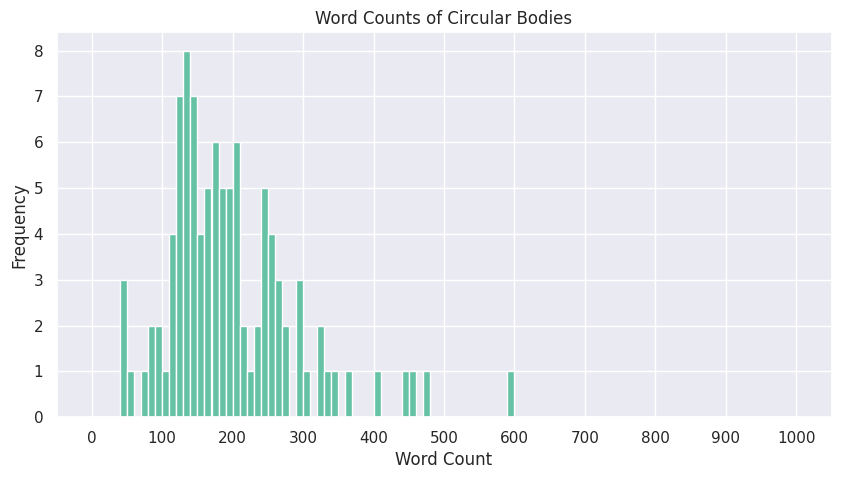

Number of circulars with > 1000 words: 0



In [ ]:
'''
Get word count distribution over all circulars.
'''
sns.set_theme()

counts=[]
for text in circular_bodies:
  counts.append(len(text.split()))

plt.figure(figsize=(10, 5))
plt.hist(counts, range=(0,1000), bins=100, color=sns.color_palette("Set2", 1))
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.title("Word Counts of Circular Bodies")
plt.xticks(np.arange(0, 1001, 100))
plt.show()

counts_over_1000 = [count>1000 for count in counts]
print(f'Number of circulars with > 1000 words: {sum(counts_over_1000)}')

print()

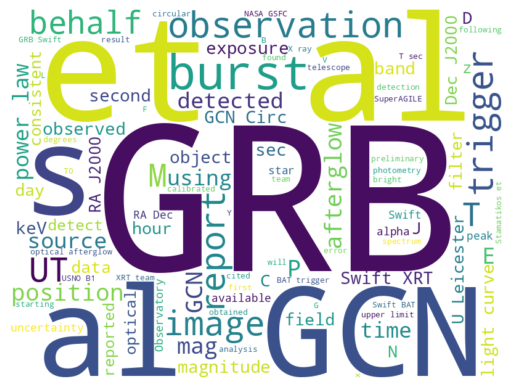

In [ ]:
from wordcloud import WordCloud

'''
Create word cloud over all GCN circulars.
Includes bigrams and trigrams of words.
'''

word_cloud = WordCloud(
    collocations = True,
    background_color = 'white',
    max_words=100,
    width=800,
    height=600).generate(' '.join(circular_bodies))

plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# '''
# Print the list of words in the word cloud
# '''

# word_frequencies = word_cloud.words_
# words = list(word_frequencies.keys())
# for word in words:
#   print(word)

Length of top 5000 keywords: 2000
Words used for the word cloud: grb, gcn, s, t, burst, afterglow, telescope, sec, swift, optical, i, kev, time, mag, h, light, bat, about, v, ra, dec, magnitude, peak, curve, energy, images, index, xrt, swiftxrt, flux, uncertainty, k, spectrum, z, image, cm, radius, photon, band, l, exposures, stars, uvot, arcsec, g, powerlaw, rc, bright, preliminary, location, emission, power, radio, seconds, photometry, law, decay, prompt, superagile, magnitudes, star, alpha, swiftbat, fit, if, duration, ks, degrees, circular, xray, erg, sigma, single, konuswind, second, followup, fermi, long, galactic, sdss, gbm, redshift, errors, transient, sources, ot, mean, previous, beginning, swiftuvot, high, containment, arcmin, smith, reports, used, initial, web, systematic, galaxy, its, guidorzi, oct, extinction, grond, find, rband, fluence, mev, model, filters, astronomy, array, break, holland, column, gsfcumbc, rxte, note, page, best, barthelmy, nearby, univ, larger, total,

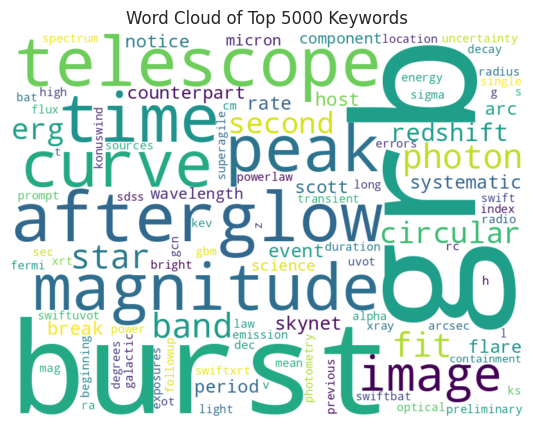

In [ ]:
#circular_bodies = circular_bodies[35000:39000]

import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Sample data (replace with your actual circular_bodies data)
circular_bodies = clean_texts  # Already cleaned circular bodies

# List of prepositions, countries, and institutes for removal
prepositions = set([
    "a", "an", "and", "the", "this", "is", "are", "may", "be", "been", "can", "has", "have", "was", "were", "we", "our", "will", "you", "also", "if"
    "about", "above", "after", "against", "along", "among", "around", "as", "at", "before",
    "behind", "below", "beneath", "beside", "between", "beyond", "but", "by", "despite", "during",
    "except", "for", "from", "in", "into", "like", "near", "of", "on", "onto", "out", "outside",
    "over", "since", "through", "throughout", "to", "under", "until", "up", "upon", "with", "within",
    "without", "how", "why", "which", "where", "when", "that", "those", "these", "here", "there", "it", "all", "each", "some", "any",
    "every", "few", "many", "much", "more", "most", "less", "least", "own", "other", "another", "such", "no", "nor", "not", "only",
    "own", "same", "either", "neither", "both", "few", "several", "one", "two", "three", "few", "either", "nor", "than", "before", "after"
])


countries = set([
    "usa", "canada", "india", "uk", "germany", "france", "china", "brazil", "japan", "south africa",
    "australia", "spain", "italy", "russia", "mexico", "south korea", "netherlands", "sweden", "norway"
])

institutes = set([
    "nasa", "harvard", "mit", "stanford", "oxford", "cambridge", "university", "institute", "research", "school", "leicester", "marshall", "gsfc"
])

custom = set(["apj", "iauc", "stanek", "report", "behalf", "team", "give", "value", "et", "al", "suggest", "indicate", "correspond",
              "thank", "support", "state", "using", "lie", "ft",  "case", "place", "using", "position", "detected", "observed",
              "ut", "rt", "message", "measurement", "observations", "data", "observatory", "consistent", "stamatikos", "reported",
              "analysis", "available", "usno", "found", "shows", "psu", "obtained", "further", "new", "check", "channel", "transformation", "series",
              "account", "coordinate", "identification", "detect", "x", "d", "e", "u", "result", "observation", "detection", "start", "exposure", "frame",
              "experiment", "real", "hour", "day", "point", "circ", "mode", "region", "year", "field", "circle", "aperature", "epoch", "confidence", "hours"
              "filter", "exp", "line", "slope", "exp", "days", "object", "unceratinity", "upper", "limit", "n", "e", "f", "starting", "p", "range", "c", "r",
              "b", "aperature", "first", "evans", "filter", "located", "following", "possible", "inaf", "isaf", "nasagsfc", "orau", "reichart", "faulke", "rt",
              "mundell", "ferrara", "henden", "crain", "raj", "decj",  "donnarumma", "usnob", "haislip", "sig", "y", "th", "inafiasf", "lacluyze", "unc", "ts", "report",
              "yield", "ivarsen", "foster", "oza", "schubel", "styblova", "trotter", "nysewander", "stack", "margutti", "inafoab", "konusrf", "jmu", "nr", "cresstusragsfc",
              "refined", "skynetprompt", "cal", "tautenburg", "dss", "faulke", "q", "nasagsfcorau", "inafiasfpa", "information", "component"
              "aavso", "cj", "clay", "code", "coordinate", "count", "curtin", "degree", "detection", "djorgovski", "ebv", "ergcm", "ergcms", "error", "exposure", "faulke",
              "feroci", "filter", "gomboc", "grba", "httpwwwswiftpsuedutoohtml", "kobayashi",  "kulkarni", "line", "ljubljana", "report", "ri" , "scuba", "source", "object",
              "stack", "stat","steele", "sys", "timeaverage", "tls", "trigger", "uc", "veillet", "yield", "october", "january", "february", "march", "april", "may", "june",
              "july", "august", "september", "october", "november", "december", "hours", "national", "approximately", "caliberate", "observing", "cited", "coolaboration", "caliberation",
              "triggered", "colleage", "hr", "aperture", "onboard", "system", "racusin", "equation", "began" , "distribution", "operation"   , "quoted" , "estimated", "caliberated","due",
              "colleague", "candidate"    , "see", "level", ".", "collaboration", "please", "made", "including", "measured", "calibrated", "results", "given", "finding", "m", "j", "begining"
              ])



# Step 1: Preprocess text to clean unwanted parts (e.g., emails, numeric values, special symbols, names, affiliations, countries, articles)
def preprocess_text(text):
    # Convert the entire text to lowercase
    text = text.lower()

    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Remove numeric values (e.g., timestamps, IDs, etc.)
    text = re.sub(r'\b\d+\b', '', text)

    # Remove potential names or affiliations (e.g., "Name:", "Author:", "Affiliation:")
    text = re.sub(r'\b(?:Name|Author|Affiliation|Contact|Institute|Organization)\b[:\s]*\w+', '', text, flags=re.IGNORECASE)

    # Remove special symbols
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters (including punctuation)

    # Remove prepositions, countries, institutes from the text
    text = ' '.join([word for word in text.lower().split() if word not in prepositions and word not in countries and word not in institutes and word not in custom])

    return text

# Step 2: Extract and count words
def extract_keywords(text):
    # Tokenize the text by splitting it into words
    tokens = text.lower().split()
    return tokens

# Step 3: Process all circular bodies to extract keywords
all_keywords = []

# Preprocess text and extract keywords from all circular bodies
for text in circular_bodies:
    cleaned_text = preprocess_text(text)
    all_keywords.extend(extract_keywords(cleaned_text))

# Step 4: Count the frequency of each keyword
keyword_counts = Counter(all_keywords)

# Step 5: Get the top 5000 most frequent words
top_5000_words = keyword_counts.most_common(2000)
top_5000_keywords = [word for word, _ in top_5000_words]

# Step 6: Print the length and list of words used for the word cloud in a line
print(f"Length of top 5000 keywords: {len(top_5000_keywords)}")
print(f"Words used for the word cloud: {', '.join(top_5000_keywords)}")

# Step 7: Generate word cloud using the top 5000 keywords
keywords_text = ' '.join(top_5000_keywords)

wordcloud = WordCloud(
    collocations=True,
    background_color='white',
    max_words=100,
    width=800,
    height=600
).generate(keywords_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 5000 Keywords")
plt.show()


Length of top 100 keywords: 2000
Words used for the word cloud: grb, gcn, s, swift, t, burst, afterglow, telescope, sec, optical, i, kev, time, mag, h, light, bat, about, v, ra, dec, magnitude, peak, curve, energy, images, index, xrt, swiftxrt, flux, uncertainty, k, spectrum, z, image, fermi, cm, radius, photon, band, l, exposures, stars, uvot, arcsec, g, powerlaw, rc, bright, preliminary, location, emission, power, radio, seconds, photometry, law, decay, prompt, superagile, magnitudes, star, alpha, swiftbat, fit, if, duration, ks, sgr, degrees, circular, xray, satellite, erg, sigma, single, konuswind, second, followup, long, galactic, sdss, gbm, redshift, errors, transient, sources, ot, mean, previous, beginning, swiftuvot, high, containment, arcmin, smith, reports, used, initial, web, systematic, galaxy, its, guidorzi, oct, extinction, grond, find, rband, fluence, mev, model, filters, astronomy, array, break, holland, column, gsfcumbc, rxte, note, page, best, barthelmy, nearby, univ,

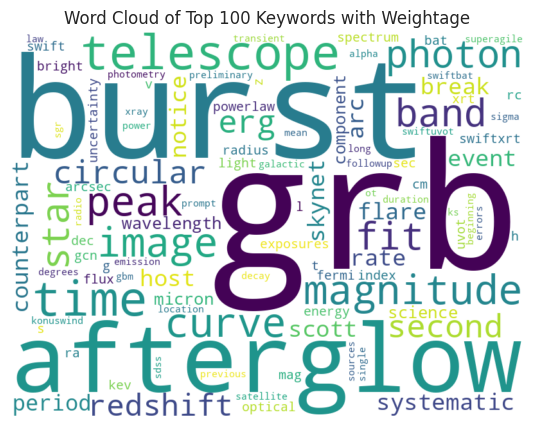

In [ ]:
import re
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Define relevant sets for astrophysical terms
telescopes = set([
    "hubble", "chandra", "swift", "fermi", "spitzer", "kepler", "panstarrs", "atlas", "soho", "jwst", "tess", "radio telescope",
    "vlt", "alma", "wsrt", "mmt", "spt", "arcminute", "lmt", "irtf", "lsst"
])

observatories = set([
    "vla", "aia", "grb", "gravitational lens", "icecube", "virgo", "ligo", "fermi", "chin", "neutrino", "xmm", "gammaray",
    "swope", "azores", "keck", "paranal", "mauna kea", "caltech", "observatory", "viper"
])

satellites = set([
    "satellite", "spitzer", "soho", "hubble", "fermi", "xmm", "nuSTAR", "tess", "chandra", "juno", "aqua", "kepler", "iris", "lisa"
])

instruments = set([
    "instrument", "camera", "spectrometer", "mri", "detector", "australian telescope", "spectrometer", "advanced camera", "nirspec",
    "swiftt", "galex", "cosmos", "james webb", "cis", "midi", "slit", "maia", "shoc", "mos", "exosat", "gaia"
])

transients = set([
    "grb", "sgr", "ep", "neutrino", "gw", "icecube", "supernova", "gravitational-wave", "ligo", "virgo", "kagra"
])

# Combine all sets into one for easier lookup
astrophysical_terms = telescopes | observatories | satellites | instruments | transients

## List of prepositions, countries, and institutes for removal
prepositions = set([
    "a", "an", "and", "the", "this", "is", "are", "may", "be", "been", "can", "has", "have", "was", "were", "we", "our", "will", "you", "also", "if"
    "about", "above", "after", "against", "along", "among", "around", "as", "at", "before",
    "behind", "below", "beneath", "beside", "between", "beyond", "but", "by", "despite", "during",
    "except", "for", "from", "in", "into", "like", "near", "of", "on", "onto", "out", "outside",
    "over", "since", "through", "throughout", "to", "under", "until", "up", "upon", "with", "within",
    "without", "how", "why", "which", "where", "when", "that", "those", "these", "here", "there", "it", "all", "each", "some", "any",
    "every", "few", "many", "much", "more", "most", "less", "least", "own", "other", "another", "such", "no", "nor", "not", "only",
    "own", "same", "either", "neither", "both", "few", "several", "one", "two", "three", "few", "either", "nor", "than", "before", "after"
])


countries = set([
    "usa", "canada", "india", "uk", "germany", "france", "china", "brazil", "japan", "south africa",
    "australia", "spain", "italy", "russia", "mexico", "south korea", "netherlands", "sweden", "norway"
])

institutes = set([
    "nasa", "harvard", "mit", "stanford", "oxford", "cambridge", "university", "institute", "research", "school", "leicester", "marshall", "gsfc"
])

custom = set(["apj", "iauc", "stanek", "report", "behalf", "team", "give", "value", "et", "al", "suggest", "indicate", "correspond",
              "thank", "support", "state", "using", "lie", "ft",  "case", "place", "using", "position", "detected", "observed",
              "ut", "rt", "message", "measurement", "observations", "data", "observatory", "consistent", "stamatikos", "reported",
              "analysis", "available", "usno", "found", "shows", "psu", "obtained", "further", "new", "check", "channel", "transformation", "series",
              "account", "coordinate", "identification", "detect", "x", "d", "e", "u", "result", "observation", "detection", "start", "exposure", "frame",
              "experiment", "real", "hour", "day", "point", "circ", "mode", "region", "year", "field", "circle", "aperature", "epoch", "confidence", "hours"
              "filter", "exp", "line", "slope", "exp", "days", "object", "unceratinity", "upper", "limit", "n", "e", "f", "starting", "p", "range", "c", "r",
              "b", "aperature", "first", "evans", "filter", "located", "following", "possible", "inaf", "isaf", "nasagsfc", "orau", "reichart", "faulke", "rt",
              "mundell", "ferrara", "henden", "crain", "raj", "decj",  "donnarumma", "usnob", "haislip", "sig", "y", "th", "inafiasf", "lacluyze", "unc", "ts", "report",
              "yield", "ivarsen", "foster", "oza", "schubel", "styblova", "trotter", "nysewander", "stack", "margutti", "inafoab", "konusrf", "jmu", "nr", "cresstusragsfc",
              "refined", "skynetprompt", "cal", "tautenburg", "dss", "faulke", "q", "nasagsfcorau", "inafiasfpa", "information", "component"
              "aavso", "cj", "clay", "code", "coordinate", "count", "curtin", "degree", "detection", "djorgovski", "ebv", "ergcm", "ergcms", "error", "exposure", "faulke",
              "feroci", "filter", "gomboc", "grba", "httpwwwswiftpsuedutoohtml", "kobayashi",  "kulkarni", "line", "ljubljana", "report", "ri" , "scuba", "source", "object",
              "stack", "stat","steele", "sys", "timeaverage", "tls", "trigger", "uc", "veillet", "yield", "october", "january", "february", "march", "april", "may", "june",
              "july", "august", "september", "october", "november", "december", "hours", "national", "approximately", "caliberate", "observing", "cited", "coolaboration", "caliberation",
              "triggered", "colleage", "hr", "aperture", "onboard", "system", "racusin", "equation", "began" , "distribution", "operation"   , "quoted" , "estimated", "caliberated","due",
              "colleague", "candidate"    , "see", "level", ".", "collaboration", "please", "made", "including", "measured", "calibrated", "results", "given", "finding", "m", "j", "begining"
              ])

# Step 1: Preprocess text to clean unwanted parts (e.g., emails, numeric values, special symbols, names, affiliations, countries, articles)
def preprocess_text(text):
    # Convert the entire text to lowercase
    text = text.lower()

    # Remove email addresses
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    # Remove numeric values (e.g., timestamps, IDs, etc.)
    text = re.sub(r'\b\d+\b', '', text)

    # Remove potential names or affiliations (e.g., "Name:", "Author:", "Affiliation:")
    text = re.sub(r'\b(?:Name|Author|Affiliation|Contact|Institute|Organization)\b[:\s]*\w+', '', text, flags=re.IGNORECASE)

    # Remove special symbols
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters (including punctuation)

    # Remove prepositions, countries, institutes from the text
    text = ' '.join([word for word in text.lower().split() if word not in prepositions and word not in countries and word not in institutes and word not in custom])

    return text

# Step 2: Extract and count words with increased weightage for astrophysical terms
def extract_keywords(text):
    # Tokenize the text by splitting it into words
    tokens = text.lower().split()
    return tokens

# Step 3: Process all circular bodies to extract keywords with weightage
all_keywords = []

# Preprocess text and extract keywords from all circular bodies
for text in circular_bodies:
    cleaned_text = preprocess_text(text)
    all_keywords.extend(extract_keywords(cleaned_text))

# Step 4: Increase the weight of astrophysical keywords
keyword_counts = Counter()

for keyword in all_keywords:
    # Increase the weight if the keyword is found in the astrophysical terms
    if keyword in astrophysical_terms:
        keyword_counts[keyword] += 2  # Add a higher weight for astrophysical terms
    else:
        keyword_counts[keyword] += 1

# Step 5: Get the top 100 most frequent words
top_100_words = keyword_counts.most_common(2000)
top_100_keywords = [word for word, _ in top_100_words]

# Step 6: Print the length and list of words used for the word cloud in a line
print(f"Length of top 100 keywords: {len(top_100_keywords)}")
print(f"Words used for the word cloud: {', '.join(top_100_keywords)}")

# Step 7: Generate word cloud using the top 100 keywords with weightage
keywords_text = ' '.join(top_100_keywords)

wordcloud = WordCloud(
    collocations=True,
    background_color='white',
    max_words=100,
    width=800,
    height=600
).generate(keywords_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 100 Keywords with Weightage")
plt.show()


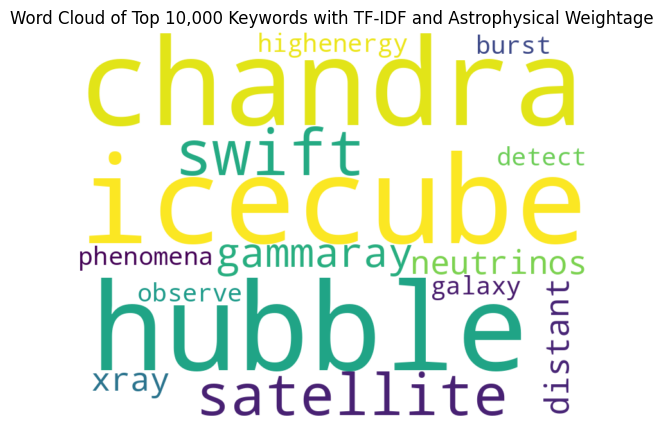

In [ ]:
import re
import spacy
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import requests

# Load the spaCy model
nlp = spacy.load("en_core_web_sm")

# Download custom stopwords file
stopwords_url = "https://raw.githubusercontent.com/ronitagarwala01/NASA_GCN_NLP/main/data/custom_stopwords.txt"
response = requests.get(stopwords_url)
custom_stopwords = set(response.text.strip().splitlines())

# Define relevant sets for astrophysical terms (same as you have)
telescopes = set([
    "hubble", "chandra", "swift", "fermi", "spitzer", "kepler", "panstarrs", "atlas", "soho", "jwst", "tess", "radio telescope",
    "vlt", "alma", "wsrt", "mmt", "spt", "arcminute", "lmt", "irtf", "lsst"
])

observatories = set([
    "vla", "aia", "grb", "gravitational lens", "icecube", "virgo", "ligo", "fermi", "chin", "neutrino", "xmm", "gammaray",
    "swope", "azores", "keck", "paranal", "mauna kea", "caltech", "observatory", "viper"
])

satellites = set([
    "satellite", "spitzer", "soho", "hubble", "fermi", "xmm", "nuSTAR", "tess", "chandra", "juno", "aqua", "kepler", "iris", "lisa"
])

instruments = set([
    "instrument", "camera", "spectrometer", "mri", "detector", "australian telescope", "spectrometer", "advanced camera", "nirspec",
    "swiftt", "galex", "cosmos", "james webb", "cis", "midi", "slit", "maia", "shoc", "mos", "exosat", "gaia"
])

transients = set([
    "grb", "sgr", "ep", "neutrino", "gw", "icecube", "supernova", "gravitational-wave", "ligo", "virgo", "kagra"
])

# Combine all sets into one for easier lookup
astrophysical_terms = telescopes | observatories | satellites | instruments | transients

## List of prepositions, countries, and institutes for removal
prepositions = set([
    "a", "an", "and", "the", "this", "is", "are", "may", "be", "been", "can", "has", "have", "was", "were", "we", "our", "will", "you", "also", "if"
    "about", "above", "after", "against", "along", "among", "around", "as", "at", "before",
    "behind", "below", "beneath", "beside", "between", "beyond", "but", "by", "despite", "during",
    "except", "for", "from", "in", "into", "like", "near", "of", "on", "onto", "out", "outside",
    "over", "since", "through", "throughout", "to", "under", "until", "up", "upon", "with", "within",
    "without", "how", "why", "which", "where", "when", "that", "those", "these", "here", "there", "it", "all", "each", "some", "any",
    "every", "few", "many", "much", "more", "most", "less", "least", "own", "other", "another", "such", "no", "nor", "not", "only",
    "own", "same", "either", "neither", "both", "few", "several", "one", "two", "three", "few", "either", "nor", "than", "before", "after"
])


countries = set([
    "usa", "canada", "india", "uk", "germany", "france", "china", "brazil", "japan", "south africa",
    "australia", "spain", "italy", "russia", "mexico", "south korea", "netherlands", "sweden", "norway"
])

institutes = set([
    "nasa", "harvard", "mit", "stanford", "oxford", "cambridge", "university", "institute", "research", "school", "leicester", "marshall", "gsfc"
])

custom = set(["apj", "iauc", "stanek", "report", "behalf", "team", "give", "value", "et", "al", "suggest", "indicate", "correspond",
              "thank", "support", "state", "using", "lie", "ft",  "case", "place", "using", "position", "detected", "observed",
              "ut", "rt", "message", "measurement", "observations", "data", "observatory", "consistent", "stamatikos", "reported",
              "analysis", "available", "usno", "found", "shows", "psu", "obtained", "further", "new", "check", "channel", "transformation", "series",
              "account", "coordinate", "identification", "detect", "x", "d", "e", "u", "result", "observation", "detection", "start", "exposure", "frame",
              "experiment", "real", "hour", "day", "point", "circ", "mode", "region", "year", "field", "circle", "aperature", "epoch", "confidence", "hours"
              "filter", "exp", "line", "slope", "exp", "days", "object", "unceratinity", "upper", "limit", "n", "e", "f", "starting", "p", "range", "c", "r",
              "b", "aperature", "first", "evans", "filter", "located", "following", "possible", "inaf", "isaf", "nasagsfc", "orau", "reichart", "faulke", "rt",
              "mundell", "ferrara", "henden", "crain", "raj", "decj",  "donnarumma", "usnob", "haislip", "sig", "y", "th", "inafiasf", "lacluyze", "unc", "ts", "report",
              "yield", "ivarsen", "foster", "oza", "schubel", "styblova", "trotter", "nysewander", "stack", "margutti", "inafoab", "konusrf", "jmu", "nr", "cresstusragsfc",
              "refined", "skynetprompt", "cal", "tautenburg", "dss", "faulke", "q", "nasagsfcorau", "inafiasfpa", "information", "component"
              "aavso", "cj", "clay", "code", "coordinate", "count", "curtin", "degree", "detection", "djorgovski", "ebv", "ergcm", "ergcms", "error", "exposure", "faulke",
              "feroci", "filter", "gomboc", "grba", "httpwwwswiftpsuedutoohtml", "kobayashi",  "kulkarni", "line", "ljubljana", "report", "ri" , "scuba", "source", "object",
              "stack", "stat","steele", "sys", "timeaverage", "tls", "trigger", "uc", "veillet", "yield", "october", "january", "february", "march", "april", "may", "june",
              "july", "august", "september", "october", "november", "december", "hours", "national", "approximately", "caliberate", "observing", "cited", "coolaboration", "caliberation",
              "triggered", "colleage", "hr", "aperture", "onboard", "system", "racusin", "equation", "began" , "distribution", "operation"   , "quoted" , "estimated", "caliberated","due",
              "colleague", "candidate"    , "see", "level", ".", "collaboration", "please", "made", "including", "measured", "calibrated", "results", "given", "finding", "m", "j", "begining"
              ])

# Combine spaCy's stopwords with custom stopwords
spacy_stopwords = set(nlp.Defaults.stop_words)
stopwords = spacy_stopwords | custom_stopwords | prepositions | institutes | countries | custom

# Step 1: Preprocess text to clean unwanted parts (e.g., emails, numeric values, special symbols, names, affiliations, countries, articles)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    text = re.sub(r'\b\d+\b', '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove non-alphabetic characters
    text = ' '.join([word for word in text.split() if word not in stopwords])  # Remove custom stopwords
    return text

# Step 2: Tokenize text using spaCy and extract lemmatized words
def extract_keywords(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and len(token.lemma_) > 1]

# Step 3: TF-IDF calculation to assign importance to rare but meaningful words
def get_tfidf_scores(documents):
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(documents)
    feature_names = vectorizer.get_feature_names_out()
    scores = tfidf_matrix.sum(axis=0).A1
    return dict(zip(feature_names, scores))

# Step 4: Process text to extract keywords and calculate TF-IDF
circular_bodies = [
    "The Hubble telescope is used to observe distant galaxies.",
    "The Chandra X-ray observatory detects high-energy phenomena.",
    "The Swift satellite observes gamma-ray bursts.",
    "Neutrinos are detected by the IceCube observatory."
]  # Example corpus

processed_texts = [preprocess_text(text) for text in circular_bodies]
all_keywords = []

# Extract keywords and calculate TF-IDF
for text in processed_texts:
    all_keywords.extend(extract_keywords(text))

# Get TF-IDF scores for all keywords in the corpus
tfidf_scores = get_tfidf_scores(processed_texts)

# Step 5: Assign higher weight to astrophysical terms
keyword_counts = Counter()

for keyword in all_keywords:
    # Boost weight if the keyword is in the astrophysical terms
    if keyword in astrophysical_terms:
        keyword_counts[keyword] += 2  # Higher weight for astrophysical terms
    else:
        keyword_counts[keyword] += 1

# Multiply keyword counts by their TF-IDF scores to add more importance to rare keywords
weighted_keywords = {}
for keyword, count in keyword_counts.items():
    tfidf_weight = tfidf_scores.get(keyword, 0)
    weighted_keywords[keyword] = count * tfidf_weight

# Step 6: Get the top 10,000 most frequent words by weighted importance
top_10000_keywords = sorted(weighted_keywords.items(), key=lambda x: x[1], reverse=True)[:10000]
top_10000_keywords = [word for word, _ in top_10000_keywords]

# Step 7: Generate word cloud using the top 10,000 keywords with weightage
keywords_text = ' '.join(top_10000_keywords)

wordcloud = WordCloud(
    collocations=True,
    background_color='white',
    max_words=10000,  # Increase max_words to 10000 for more words in the cloud
    width=800,
    height=600
).generate(keywords_text)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Top 10,000 Keywords with TF-IDF and Astrophysical Weightage")
plt.show()


#Step 6: Embed our Circulars

In [8]:
'''
Embed our circulars using the base all-MiniLM-L6-v2 model.
'''

# Default model. Really fast, but only has context window of 256 tokens
model = SentenceTransformer("all-MiniLM-L6-v2")
minilm_l6_embeddings = model.encode(circular_bodies, show_progress_bar=True)
np.save('minilm_l6_embeddings.npy', minilm_l6_embeddings)

.gitattributes:   0%|          | 0.00/1.23k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

model.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O1.onnx:   0%|          | 0.00/90.4M [00:00<?, ?B/s]

model_O2.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O3.onnx:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

model_O4.onnx:   0%|          | 0.00/45.2M [00:00<?, ?B/s]

model_qint8_arm64.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_qint8_avx512_vnni.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

model_quint8_avx2.onnx:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

openvino_model.bin:   0%|          | 0.00/90.3M [00:00<?, ?B/s]

openvino/openvino_model.xml:   0%|          | 0.00/211k [00:00<?, ?B/s]

openvino_model_qint8_quantized.bin:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

(…)nvino/openvino_model_qint8_quantized.xml:   0%|          | 0.00/368k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/1217 [00:00<?, ?it/s]

#Step 7: Embedding Model Evaluation with Zero-Shot Topic Modelling

In [10]:
'''
We will now test our topic models on a small pre-defined dataset.
We have gathered GCN circulars belonging to the following categories:
  -High-Energy Observations
  -Optical Observations
  -Radio
  -Neutrino
  -Gravitational Wave
In total we have 72 circulars in our dataset.
Our goal is to find the topic model that can correctly classify most of these circulars based on Zero-Shot Classification.
'''

# Prepare dataset
gw = [38986, 38978, 38975, 38973, 38971, 38932, 38863, 38860, 38856, 38851,
38812, 38760, 38747, 38737, 38735, 38722, 38670, 38666, 38521, 38515,
38512, 38402, 38393, 38391, 38377, 38356, 38336, 38332, 38312, 38309,
38305, 38303, 38301, 38255, 38228, 38210, 38204, 38166, 38155, 38144,
38142, 38138, 38070, 38045, 38043, 38036, 37776, 37750, 37745, 37743,
37587, 37586, 37571, 37562, 37552, 37534, 37530, 37514, 37512, 37446,
37727, 37719, 37718, 37663, 37646, 37634, 37604, 37595, 37592, 37591,
37354, 37268, 37170, 37168, 37096, 36879, 36826, 36816, 36794, 36784,
36772, 36747, 36742, 36738, 36735, 36733, 36342, 20486, 20364, 19341,
18889, 18858, 18850, 18728, 18626, 18442, 21474, 21934, 21489, 21493]

gw_counterpart = [39009, 38993, 38957, 38939, 38783, 38757, 38748, 38745, 38742, 38679,
38493, 38443, 38417, 38396, 38370, 38351, 38348, 38345, 38334, 38333,
38324, 38317, 38316, 38308, 38272, 38231, 38169, 38168, 38156, 38154,
38151, 38146, 38102, 38101, 38056, 38044, 37884, 37777, 37699, 37644,
37621, 37611, 37609, 37590, 37589, 37528, 37527, 37454, 37451, 37448,
37440, 37381, 36972, 36924, 36871, 36850, 36837, 36800, 36793, 36755,
36705, 36698, 36688, 36610, 36579, 36571, 36565, 36526, 36495, 36468,
21503, 21497, 21481, 21477, 21476, 21475, 21890, 21885, 21878, 21860,
20402, 20399, 20398, 20395, 20393, 20390, 20376, 20371, 20370, 19315,
19055, 18870, 18834, 18813, 18776, 18621, 18451, 18448, 18446, 18359]

gw_false = [38725, 38724, 38658, 38610, 39040, 39039, 39038, 39037, 39036, 39035,
39034, 39033, 39032, 39031, 39030, 39029, 39028, 39028, 39023, 39018,
38841, 38842, 38843, 38844, 38845, 38846, 38847, 38848, 38849, 38850,
38852, 38853, 38854, 38855, 38857, 38858, 38746, 38749, 38750, 38753,
214,    215,    216,   217,    218,     314,   313,   312,   311,  310,
38754, 38740, 38739, 38738, 38736, 38730, 38727, 38540, 38539, 38538,
38537, 38536, 38535, 38534, 38529, 38439, 38438, 38437, 38436, 38435,
38434, 38241, 38242, 38245, 38246, 38247, 38248, 38239, 38235, 38234,
38229, 38219, 38220, 38221, 38222, 38212, 38205, 38206, 38207, 38208,
38088, 38089, 38090, 38091, 38092, 38093, 38094, 38095, 38096, 38097]

gw_train, gw_test = train_test_split(gw, test_size=0.2, random_state=0)

gw_counterpart_train, gw_counterpart_test = train_test_split(gw_counterpart, test_size=0.2, random_state=0)

gw_false_train, gw_false_test = train_test_split(gw_false, test_size=0.2, random_state=0)

train_observation_labels = []
test_observation_labels = []

# Get Training Set
for circular in circulars:
  if circular["circularId"] in gw_train:
    train_observation_labels.append("Gravitational Wave")
  elif circular["circularId"] in gw_counterpart_train:
    train_observation_labels.append("Gravitational Wave Counterpart")
  elif circular["circularId"] in gw_false_train:
    train_observation_labels.append("Not Gravitational Wave")
  else:
    train_observation_labels.append("")

# Get Test Set
for circular in circulars:
  if circular["circularId"] in gw_test:
    test_observation_labels.append("Gravitational Wave")
  elif circular["circularId"] in gw_counterpart_test:
    test_observation_labels.append("Gravitational Wave Counterpart")
  elif circular["circularId"] in gw_false_test:
    test_observation_labels.append("Not Gravitational Wave")
  else:
    test_observation_labels.append("")

print(len(train_observation_labels))
print(len(test_observation_labels))

print(len(gw_train))
print(len(gw_test))

print(len(gw_counterpart_train))
print(len(gw_counterpart_test))

print(len(gw_false_train))
print(len(gw_false_test))

38919
38919
80
20
80
20
80
20


In [11]:
'''
We will perform Zero-Shot Topic Modelling to match circulars to pre-defined cadidate labels.
We'll be using a cosine similarity with various thresholds to match topic labels to circulars.
For the circulars that don't match any of the labels above our threshold we perform regular Topic Modelling.
Finally, we calculate accuracy scores for each embedding model and cosine threshold based on our dataset.
'''

embeddings_list = ["Base Model", "Epoch 1", "Epoch 2", "Epoch 3"]
accuracy_scores = pd.DataFrame(index=["Train", "Test"], columns=embeddings_list)

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

candidate_topics = ["Gravitational Wave", "Gravitational Wave Counterpart", "Not Gravitational Wave"]

In [12]:
vectorizer_model = CountVectorizer()

'''
Compute accuracy for all-MiniLM-L6-v2 embeddings on training set
'''

embeddings = np.load("minilm_l6_embeddings.npy")
model = SentenceTransformer("all-MiniLM-L6-v2")
error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
topic_model = BERTopic(verbose=True,
                       umap_model=umap_model,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.2, ## assign topic to each circular
                       embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])
#print(topic_labels[10:20])

score = 0
for i, label in enumerate(train_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Train", "Base Model"] = accuracy

2025-02-01 23:31:51,851 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-02-01 23:31:52,453 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-02-01 23:31:52,458 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-01 23:32:29,109 - BERTopic - Dimensionality - Completed ✓
2025-02-01 23:32:29,112 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-02-01 23:32:29,780 - BERTopic - Cluster - Completed ✓
2025-02-01 23:32:29,801 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-02-01 23:32:31,762 - BERTopic - Representation - Completed ✓
2025-02-01 23:32:33,939 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-02-01 23:32:33,957 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-02-01 23:32:33,960 - BERTopic - Dimensionality - Completed ✓
2025-02-01 23:32

Raw Score: 52
Raw Error: 188


In [ ]:

'''
Compute accuracy scores for base model on test set
'''

error_count=0

topic_model = BERTopic(verbose=True,
                      umap_model=umap_model,
                      vectorizer_model=vectorizer_model,
                      zeroshot_topic_list=candidate_topics,
                      zeroshot_min_similarity=0.2,
                      embedding_model=model)

topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

topic_labels=[]
for topic in topics:
  topic_labels.append(topic_model.topic_labels_[topic])

score = 0
for i, label in enumerate(test_observation_labels):
  if label != "":
    if topic_labels[i] == label:
      score += 1
    else:
      error_count += 1

print(f"Raw Score: {score}")
print(f"Raw Error: {error_count}")
accuracy = (score / (score + error_count)) * 100
accuracy_scores.at["Test", "Base Model"] = accuracy

2025-01-27 16:51:14,278 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-01-27 16:51:14,616 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-01-27 16:51:14,619 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-27 16:51:24,549 - BERTopic - Dimensionality - Completed ✓
2025-01-27 16:51:24,551 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-27 16:51:25,151 - BERTopic - Cluster - Completed ✓
2025-01-27 16:51:25,162 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-27 16:51:27,948 - BERTopic - Representation - Completed ✓
2025-01-27 16:51:30,138 - BERTopic - Zeroshot Step 2 - Clustering documents that were not found in the zero-shot model...
2025-01-27 16:51:30,155 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-01-27 16:51:30,158 - BERTopic - Dimensionality - Completed ✓
2025-01-27 16:51

Raw Score: 15
Raw Error: 45


In [ ]:
#accuracy_scores

We can see that the all-MiniLM-L6-v2 achieves an accuracy of 66.875% and 65% on the train and test set respectively straight out of the box. Let us now see if further fine-tuning can help further improve our clustering accuracy.

#Step 8: Contrastive Fine-Tuning

In [ ]:
'''
We will now fine-tune our sentence embedder model using Contrastive Loss.
The goal is to fine-tune our embeddings so that circulars belong to similar topics are embedded more closely,
while circulars belonging to dissimilar topics are embedded far away in the vector space.
Theoretically this should help improve our zero-shot topic modelling accuracy.
We'll be using the same event-based circular dataset as before.
'''

# Prepare Dataset
event_dataset = []
for text, label in zip(circular_bodies, train_observation_labels):
  example = {}
  if label != "":
    example["text"] = text
    example["label"] = candidate_topics.index(label)
    event_dataset.append(example)

print(len(event_dataset))
unique_values = {d["label"] for d in event_dataset if "label" in d}
print(unique_values)

240
{0, 1, 2}


In [ ]:
# Prepare Similar Event Dataset
event_pair_dataset = []
for i in event_dataset:
  for j in event_dataset:
    if i == j:
      continue
    example={}
    example["texts"] = [i["text"], j["text"]]
    if i["label"] == j["label"]:
      example["label"] = 1
    else:
      example["label"] = 0
    event_pair_dataset.append(example)

print(len(event_pair_dataset))
#print(event_pair_dataset[0]["texts"][0])
#print(event_pair_dataset[1]["label"])

#print(event_pair_dataset[0]["texts"][1])
#print(event_pair_dataset[1]["label"])

57360


In [ ]:
'''
Train for 1 epoch on the training set
'''

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=1,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_1")

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

In [ ]:
'''
Train for 2 epochs on the training set
'''

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=2,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_2")

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

In [ ]:
'''
Train for 3 epochs on the training set
'''

# Set seeds to help reproducibility
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
seed_value = 42
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
torch.use_deterministic_algorithms(True)

# Prepare Training Examples, Loss, and Model (all-MiniLM-L6-v2)
model = SentenceTransformer("all-MiniLM-L6-v2")
train_examples = [InputExample(texts=example["texts"], label=example["label"]) for example in event_pair_dataset]

# Prepare DataLoader Object
train_dataloader = DataLoader(train_examples,
                              shuffle=True,
                              batch_size=1,
                              num_workers=0)
train_size = len(train_dataloader)

# Use Contrastive Training Loss
train_loss = losses.ContrastiveLoss(model=model)

# Tune the model
model.fit(train_objectives=[(train_dataloader, train_loss)],
          epochs=3,
          warmup_steps=100)

# Save the model
model.save("tuned_mini_lm_3")

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

Iteration:   0%|          | 0/57360 [00:00<?, ?it/s]

In [ ]:
# Get new all-MiniLM-L6-v2 embeddings
model_1 = SentenceTransformer("/content/tuned_mini_lm_1")
model_2 = SentenceTransformer("/content/tuned_mini_lm_2")
model_3 = SentenceTransformer("/content/tuned_mini_lm_3")

tuned_embeddings_1 = model_1.encode(circular_bodies, show_progress_bar=True)
tuned_embeddings_2 = model_2.encode(circular_bodies, show_progress_bar=True)
tuned_embeddings_3 = model_3.encode(circular_bodies, show_progress_bar=True)

In [ ]:
from google.colab import files
import numpy as np

np.save('tuned_embeddings_1.npy', tuned_embeddings_1)
np.save('tuned_embeddings_2.npy', tuned_embeddings_2)
np.save('tuned_embeddings_3.npy', tuned_embeddings_3)

files.download('tuned_embeddings_1.npy')
files.download('tuned_embeddings_2.npy')
files.download('tuned_embeddings_3.npy')

In [ ]:
'''
Compute training accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,4):
  embeddings = eval(f"tuned_embeddings_{i}")
  model = eval(f"model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(train_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Train", epoch] = accuracy

NameError: name 'vectorizer_model' is not defined

In [ ]:
'''
Compute test accuracy for fine-tuned all-MiniLM-L6-v2 embeddings
'''

error_count=0

# Compute accuracy scores based on number of matches between candidate labels and topic model labels
for i in range(1,4):
  embeddings = eval(f"tuned_embeddings_{i}")
  model = eval(f"model_{i}")
  topic_model = BERTopic(verbose=True,
                         umap_model=umap_model,
                         vectorizer_model=vectorizer_model,
                         zeroshot_topic_list=candidate_topics,
                         zeroshot_min_similarity=0.1,
                         embedding_model=model)

  topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

  topic_labels=[]
  for topic in topics:
    topic_labels.append(topic_model.topic_labels_[topic])

  score = 0
  error_count = 0
  for j, label in enumerate(test_observation_labels):
    if label != "":
      if topic_labels[j] == label:
        score += 1
      else:
        error_count += 1

  print(f"Raw Score for Epoch {i}: {score}")
  print(f"Raw Error for Epoch {i}: {error_count}")
  accuracy = (score / (score + error_count)) * 100
  epoch = f"Epoch {i}"
  accuracy_scores.at["Test", epoch] = accuracy

In [ ]:
accuracy_scores

In [ ]:
'''
Create latex table for accuracy scores
'''

accuracy_latex_table = accuracy_scores.to_latex(float_format="%.2f")
accuracy_latex_table

'\\begin{tabular}{lllll}\n\\toprule\n & Base Model & Epoch 1 & Epoch 2 & Epoch 3 \\\\\n\\midrule\nTrain & 50.00 & 0.00 & NaN & NaN \\\\\nTest & 40.00 & 60.00 & NaN & NaN \\\\\n\\bottomrule\n\\end{tabular}\n'

We see that with contrastive fine-tuning we are able to increase the classification accuracy of our pipeline to 100% on the train set and 90% on the test set after 2 epochs of training. Further training does not yield better results, likely due to overfitting.

#Step 9: Perform Topic Modelling

In [ ]:
'''
Initialize Llama cpp model and AutoTokenizer
'''
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.2")
llm = Llama(model_path="mistral-7b-instruct-v0.2.Q4_K_M.gguf",
            n_gpu_layers=-1,
            n_ctx=32768)

In [ ]:
start_time = time.time()
'''
We will now perform topic modelling with BERTopic.
We use the default all-MiniLM-L6-v2 and a minimum topic size of 100 which gave the best coherence score for this model.
In addition, we will use a 4-bit quantized version of the new Mistral-7B-Instruct LLM for topic label generation.
This open sorce model has been shown to have superior performance to Llama 2 13B on multiple benchmarks.
It has been fine-tuned using publicly available conversation datasets.
'''

# Set number of threads to 1 and set other os environment variables for reproducibility
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.set_num_threads(1)

seed_value = 42  # Set the random seed
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
torch.use_deterministic_algorithms(True)

# Build representation model with mistral and llama cpp
# Use a custom prompt for label generation
prompt = """Q: I have a topic that contains the following representative circulars among hundreds of others:
[DOCUMENTS]

The topic is described by the following keywords: '[KEYWORDS]'.

Based on the above information, can you give a short label of the topic?
A: """

representation_model = LlamaCPP(model=llm,
                                prompt=prompt,
                                doc_length=768,
                                tokenizer=tokenizer,
                                pipeline_kwargs={"max_tokens": 128,
                                                 "stop": "Q:",
                                                 "temperature": 0.0})

embeddings = np.load("minilm_l6_embeddings.npy")

# Fix random state in UMAP for reproducibility
umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Set number of cores to one to turn off multi-threading. This should help with reproducibility.
# Set minimum cluster size to 400. This will iteratively merge smaller clusters to form bigger ones.
# Set minimum samples to 10. This will make sure only clusters smaller than 10 are treated as outliers.
hdbscan_model = HDBSCAN(min_cluster_size=400,
                        min_samples=10,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True,
                        core_dist_n_jobs=1)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       umap_model=umap_model,
                       hdbscan_model=hdbscan_model,
                       vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(circular_bodies, embeddings)

end_time = time.time()
print(end_time - start_time)

In [ ]:
# Display topics
freq = topic_model.get_topic_info()
freq.head(30)

In [ ]:
'''
Apply t-SNE to reduce the dimensionality of the embeddings and visualize the clusters.
'''

reduced_embeddings = TSNE(n_components=2, n_jobs=1, random_state=0, verbose=2).fit_transform(embeddings)

fig = go.Figure()
tsne_df = pd.DataFrame()
tsne_df["x"], tsne_df["y"] = reduced_embeddings[:, 0], reduced_embeddings[:, 1]
tsne_df["topics"] = [topic_model.topic_labels_[i] for i in topics]

unique_topics = list(topic_model.topic_labels_.values())[1:]
light24 = px.colors.qualitative.Light24
dark24 = px.colors.qualitative.Dark24
colors = light24[0:11] + [dark24[9]] + dark24[5:8] + dark24[15:17] + [dark24[13]] + [light24[22]] + [light24[17]]
color_cycle = itertools.cycle(colors)

for label in unique_topics:
    sub_df = tsne_df.loc[tsne_df["topics"] == label]
    fig.add_trace(
        go.Scattergl(
            x=sub_df["x"],
            y=sub_df["y"],
            mode="markers",
            name=str(label[label.find('_')+1:]) + " (" + str(sub_df.shape[0]) + ")",
            marker=dict(
                color=next(color_cycle),
                size=5,
                opacity=0.5,
            )
        )
    )

fig.update_traces(
  marker=dict(
    size=5,
    opacity=0.5,
  )
)

fig.update_layout(
  title={
    'text': "<b>General Coordinates Network (GCN): Key Astrophysical Topics</b>",
    'x': 0.5,
    'xanchor': 'center'
  },
  width=1200,
  height=800,
  legend_title_text="Topics (Circular Counts)",
  legend=dict(
    x=1.05,
    y=1,
    traceorder='normal',
    bgcolor='rgba(0,0,0,0)',
    bordercolor='rgba(0,0,0,0)'
  ),
  xaxis=dict(
    showticklabels=False
  ),
  yaxis=dict(
    showticklabels=False
  )
)

In [ ]:
'''
Generate topic summaries with Mistral 7B Instruct and update representations
'''

topic_model.update_topics(circular_bodies,
                          representation_model=representation_model)

In [ ]:
# Display topic summaries
freq = topic_model.get_topic_info()
freq.head(30)

In [ ]:
'''
Get table with just Topic Summaries and Frequencies
'''
sub_freq = freq[['Representation', 'Count']].copy()
sub_freq['Topic Summary'] = freq['Representation'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
sub_freq['Circular Count'] = freq['Count']
sub_freq.drop('Representation', axis=1, inplace=True)
sub_freq.drop('Count', axis=1, inplace=True)

In [ ]:
sub_freq.drop(index=0, inplace=True) # Drop outlier row
sub_freq

In [ ]:
latex_table = sub_freq.to_latex(index=False)
latex_table

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''
topic_model.visualize_topics()

In [ ]:
'''
Perform hierarchical reduction on our topic model.
Viualize these hierarchies to better understand the relations between our topics.
'''

hierarchical_topics = topic_model.hierarchical_topics(circular_bodies)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

In [ ]:
'''
Visualize hierarchical topic clusters
'''
topic_model.visualize_hierarchical_documents(circular_bodies, hierarchical_topics, embeddings=embeddings, topics=list(range(20)))

In [ ]:
'''
Display a Similarity Matrix for all Topics
'''
topic_model.visualize_heatmap(topics=list(range(20)), width=650, height=650)

In [ ]:
'''
Create word cloud over top 10 topics
'''

fig, axs = plt.subplots(20, 1, figsize=(10, 80)) # Create a figure with 10 subplots vertically arranged

# Join all documents of a topic together and generate word cloud
for topic_num, ax in enumerate(axs):
    word_cloud = WordCloud(
        collocations=True,
        background_color='white',
        max_words=100,
        width=1000,
        height=800,
        stopwords=new_stop_words).generate(' '.join([text for i, text in enumerate(circular_bodies) if topics[i] == topic_num]))

    ax.imshow(word_cloud, interpolation='bilinear')
    ax.set_title(topic_model.topic_representations_[topic_num][0][0])
    ax.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

#Step 10: Trend Analysis

In [ ]:
'''
We will now perform Trend Analysis over the topic clusters.
'''
num_topics = len(freq) - 1  # Subtract 1 to exclude outlier row

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)

light24 = px.colors.qualitative.Light24
dark24 = px.colors.qualitative.Dark24
colors = light24[0:11] + [dark24[9]] + dark24[5:8] + dark24[15:17] + [dark24[13]] + [light24[22]] + [light24[17]]
color_cycle = itertools.cycle(colors)

fig, ax = plt.subplots(figsize=(12, 6))

for k in range(num_topics):
    topic_dates = []  # List to store dates for topic k
    all_dates = []  # List to store all dates

    # Iterate over all timestamps and check their respective document's topic
    # If topic matches k, append its timestamp (as DateTime object) to topic_dates
    for i, time_stamp in enumerate(time_stamps):
        if time_stamp == 0:  # Discard invalid dates
            continue
        if topics[i] == k:
            topic_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))  # Append datetime object to topic_dates
        all_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))

    my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

    # Iterate through each topic in our topic_dates dict and create histogram
    sns.histplot(topic_dates,
                 bins=mdates.date2num(my_bins),
                 alpha=0.6,
                 linewidth=0.2,
                 color=next(color_cycle),
                 ax=ax,
                 label=topic_model.topic_representations_[k][0][0].replace('\n', ''))

# Calculate the number of 6-month intervals between start and end dates
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

# Calculate the adjusted end date based on the number of intervals
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

plt.xlim(start_date, adjusted_end_date)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Key GCN Topics Over Time", fontsize=18, fontweight="bold", y=1.02)
plt.grid(axis="both", linestyle="-", alpha=0.5)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize=12)

plt.tight_layout()
plt.show()

# fig, axes = plt.subplots(num_topics, 1, figsize=(18, 6 * num_topics), sharex=True)

# for k in range(num_topics):
#     ax = axes[k]
#     topic_dates = []  # List to store dates for topic k
#     all_dates = []  # List to store all dates

#     # Iterate over all timestamps and check their respective document's topic
#     # If topic matches k, append its timestamp (as DateTime object) to topic_dates
#     for i, time_stamp in enumerate(time_stamps):
#         if time_stamp == 0:  # Discard invalid dates
#             continue
#         if topics[i] == k:
#             topic_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))  # Append datetime object to topic_dates
#         all_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))

#     my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

#     # Create histogram for the topic
#     sns.histplot(topic_dates,
#                  bins=mdates.date2num(my_bins),
#                  alpha=1.0,
#                  linewidth=0.2,
#                  color=next(color_cycle),
#                  ax=ax)

#     # Calculate the number of 6-month intervals between start and end dates
#     start_date = min(all_dates)
#     end_date = max(all_dates)
#     num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

#     # Calculate the adjusted end date based on the number of intervals
#     adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

#     ax.set_xlim(start_date, adjusted_end_date)
#     ax.xaxis.set_major_locator(mdates.YearLocator(2))
#     ax.set_xlabel("Year", fontsize=14, fontweight="bold")
#     ax.set_ylabel("Number of Circulars", fontsize=14, fontweight="bold")
#     ax.set_title(topic_model.topic_representations_[k][0][0], fontsize=18, fontweight="bold", y=1.02)
#     ax.grid(axis="both", linestyle="-")

# plt.tight_layout()
# plt.show()

In [ ]:
'''
Get histogram for some key topics
'''

num_topics = len(freq) - 1  # Subtract 1 to exclude outlier row
important_topics_list = [2, 3, 5, 13]

sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
custom_colors = ['#e8000b', '#023eff', '#ff7c00', '#1ac938', '#8b2be2']
custom_palette =  sns.color_palette(custom_colors)

fig, ax = plt.subplots(figsize=(12, 6))

for j, k in enumerate(important_topics_list):
    topic_dates = []  # List to store dates for topic k
    all_dates = []  # List to store all dates

    # Iterate over all timestamps and check their respective document's topic
    # If topic matches k, append its timestamp (as DateTime object) to topic_dates
    for i, time_stamp in enumerate(time_stamps):
        if time_stamp == 0:  # Discard invalid dates
            continue
        if topics[i] == k:
            topic_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))  # Append datetime object to topic_dates
        all_dates.append(datetime.utcfromtimestamp(time_stamp / 1000))

    my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

    # Iterate through each topic in our topic_dates dict and create histogram
    sns.histplot(topic_dates,
                 bins=mdates.date2num(my_bins),
                 alpha=0.6,
                 linewidth=0.2,
                 color=custom_palette[j],
                 ax=ax,
                 label=topic_model.topic_representations_[k][0][0])

# Calculate the number of 6-month intervals between start and end dates
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

# Calculate the adjusted end date based on the number of intervals
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

plt.xlim(start_date, adjusted_end_date)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(4))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Key GCN Topics Over Time", fontsize=18, fontweight="bold", y=1.02)
plt.grid(axis="both", linestyle="-", alpha=0.5)
plt.legend(bbox_to_anchor=(0.5, -0.2), loc='upper center', fontsize=12)

plt.tight_layout()
plt.show()

#Step 11: Zero-Shot Topic Modelling for Predefined Topics

In [ ]:
'''
We'll now perform topic modelling again but with Zero-Shot enabled.
We will use our fine-tuned all-MiniLM-L6-v2 model for this which was tuned for 2 epochs.
We attempt to fit our topics into pre-defined candidate labels using zero-shot topic modelling.
'''
candidate_topics = ["Gravitational Wave",
                    "Gravitational Wave Counterpart",
                    "No Gravitational Wave"]

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       embedding_model=model_1,
                       umap_model=umap_model,
                       min_topic_size=100,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.2)

topics, probs = topic_model.fit_transform(circular_bodies, tuned_embeddings_1)
topic_labels = [value for key, value in topic_model.topic_labels_.items()]
topic_model.set_topic_labels(topic_labels)

# Display top 10 topics
freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
circular_topic_df = pd.DataFrame()
circular_topic_df["Circular"] = circular_bodies
circular_topic_df["Topic"] = [topic_model.topic_labels_[i] for i in topics]
circular_topic_df["Circular ID"] = circulars["circularId"]

circular_topic_df.head()

In [ ]:
circular_topic_df.to_csv('circular_topic_data.csv', index=False)
circular_topic_latex = circular_topic_df.to_latex(index=False)
print(circular_topic_latex)

Buffered data was truncated after reaching the output size limit.

In [ ]:
'''
We'll now perform topic modelling again but with Zero-Shot enabled.
We will use our fine-tuned all-MiniLM-L6-v2 model for this which was tuned for 2 epochs.
We attempt to fit our topics into pre-defined candidate labels using zero-shot topic modelling.
'''
candidate_topics = ["Gravitational Wave",
                    "Gravitational Wave Counterpart",
                    "No Gravitational Wave"]

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       embedding_model=model_2,
                       umap_model=umap_model,
                       min_topic_size=100,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.2)

topics, probs = topic_model.fit_transform(circular_bodies, tuned_embeddings_2)
topic_labels = [value for key, value in topic_model.topic_labels_.items()]
topic_model.set_topic_labels(topic_labels)

# Display top 10 topics
freq = topic_model.get_topic_info()
freq.head(10)

2025-01-27 19:03:03,217 - BERTopic - Zeroshot Step 1 - Finding documents that could be assigned to either one of the zero-shot topics
2025-01-27 19:03:03,516 - BERTopic - Zeroshot Step 1 - Completed ✓
2025-01-27 19:03:03,519 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm


KeyboardInterrupt: 

In [ ]:
circular_topic_df = pd.DataFrame()
circular_topic_df["Circular"] = circular_bodies
circular_topic_df["Topic"] = [topic_model.topic_labels_[i] for i in topics]
circular_topic_df["Circular ID"] = circulars["circularId"]

circular_topic_df.head()

In [ ]:
circular_topic_df.to_csv('circular_topic_data.csv', index=False)
circular_topic_latex = circular_topic_df.to_latex(index=False)
print(circular_topic_latex)

In [ ]:
'''
We'll now perform topic modelling again but with Zero-Shot enabled.
We will use our fine-tuned all-MiniLM-L6-v2 model for this which was tuned for 2 epochs.
We attempt to fit our topics into pre-defined candidate labels using zero-shot topic modelling.
'''
candidate_topics = ["Gravitational Wave",
                    "Gravitational Wave Counterpart",
                    "No Gravitational Wave"]

umap_model = UMAP(n_neighbors=15,
                  n_components=5,
                  min_dist=0.0,
                  metric='cosine',
                  low_memory=False,
                  random_state=0)

# Build Topic Model with BERTopic
topic_model = BERTopic(verbose=True,
                       embedding_model=model_3,
                       umap_model=umap_model,
                       min_topic_size=100,
                       vectorizer_model=vectorizer_model,
                       zeroshot_topic_list=candidate_topics,
                       zeroshot_min_similarity=0.2)

topics, probs = topic_model.fit_transform(circular_bodies, tuned_embeddings_3)
topic_labels = [value for key, value in topic_model.topic_labels_.items()]
topic_model.set_topic_labels(topic_labels)

# Display top 10 topics
freq = topic_model.get_topic_info()
freq.head(10)

In [ ]:
circular_topic_df = pd.DataFrame()
circular_topic_df["Circular"] = circular_bodies
circular_topic_df["Topic"] = [topic_model.topic_labels_[i] for i in topics]
circular_topic_df["Circular ID"] = circulars["circularId"]

circular_topic_df.head()

In [ ]:
circular_topic_df.to_csv('circular_topic_data.csv', index=False)
circular_topic_latex = circular_topic_df.to_latex(index=False)
print(circular_topic_latex)

Buffered data was truncated after reaching the output size limit.

In [ ]:
'''
Apply UMAP to reduce the dimensionality of the embeddings and visualize the clusters.
'''

reduced_embeddings = UMAP(n_components=2, random_state=0).fit_transform(tuned_embeddings_2)

fig = go.Figure()
umap_df = pd.DataFrame()
umap_df["x"], umap_df["y"] = reduced_embeddings[:, 0], reduced_embeddings[:, 1]
umap_df["topics"] = [topic_model.topic_labels_[i] for i in topics]

for label in list(topic_model.topic_labels_.values()):
  sub_df = umap_df.loc[umap_df["topics"] == label]
  fig.add_trace(
    go.Scattergl(
      x=sub_df["x"],
      y=sub_df["y"],
      mode="markers",
      name=str(label[label.find('_')+1:]) + " (" + str(sub_df.shape[0]) + ")",
    )
  )

fig.update_traces(
  marker=dict(
    size=5,
    opacity=0.5,
  )
)

fig.update_layout(
  title={
    'text': "<b>General Coordinates Network (GCN): Observation-Based Topic Clusters</b>",
    'x': 0.5,
    'xanchor': 'center'
  },
  width=1200,
  height=800,
  legend_title_text="Topics (Circular Counts)",
  legend=dict(
    x=1.05,
    y=1,
    traceorder='normal',
    bgcolor='rgba(0,0,0,0)',
    bordercolor='rgba(0,0,0,0)'
  ),
  xaxis=dict(
    showticklabels=False
  ),
  yaxis=dict(
    showticklabels=False
  )
)

NameError: name 'tuned_embeddings_2' is not defined

In [ ]:
'''
Visualise topics in a 2-D space using UMAP
'''

topic_model.visualize_topics()

In [ ]:
fig = topic_model.visualize_barchart(n_words=10, custom_labels=True, height=500, width=500)
fig.show()

In [ ]:
# Display a Similarity Matrix for all Topics
topic_model.visualize_heatmap(width=850, height=650)

In [ ]:
'''
Create word cloud over our candidate topics
'''

fig, axs = plt.subplots(len(candidate_topics), 1, figsize=(10, 60))

# Join all documents of a candidate topic together and generate word cloud
for topic_num, ax in enumerate(axs):
  word_cloud = WordCloud(
        collocations=True,
        background_color='white',
        max_words=100,
        width=1000,
        height=800).generate(' '.join([text for i, text in enumerate(circular_bodies) if topic_model.topic_labels_[topics[i]] == candidate_topics[topic_num]]))

  ax.imshow(word_cloud, interpolation='bilinear')
  ax.set_title(candidate_topics[topic_num], fontsize=18, fontweight="bold", y=1.05)
  ax.axis("off")

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
'''
We will now perform Trend Analysis over our Topic Clusters.
'''

num_topics = len(freq)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(18, 6))
custom_colors = ['#023eff', '#ff7c00', '#1ac938', '#8b2be2', '#e8000b']
custom_palette =  sns.color_palette(custom_colors)

for k in range(num_topics):
  topic_dates = [] # List to store dates for topic k
  all_dates = [] # List to store all dates

  # Iterate over all timestamps and check their respective document's topic
  # If topic matches k, append its timestamp (as DateTime object) to topic_dates
  for i, time_stamp in enumerate(time_stamps):
      if time_stamp == 0: # Discard invalid dates
          continue
      if topics[i] == k:
          topic_dates.append(datetime.utcfromtimestamp(time_stamp/1000)) # Append datetime object to topic_dates
      all_dates.append(datetime.utcfromtimestamp(time_stamp/1000))

  my_bins = pd.date_range(start=min(all_dates), end=max(all_dates), freq='6M')

  # Iterate through each topic in our topic_dates dict and create histogram
  sns.histplot(topic_dates,
               bins=mdates.date2num(my_bins),
               alpha=0.5,
               linewidth=0.2,
               color=custom_palette[k],
               label=topic_model.topic_labels_[k])

# Calculate the number of 6-month intervals between start and end dates
start_date = min(all_dates)
end_date = max(all_dates)
num_intervals = (end_date.year - start_date.year) * 2 + (end_date.month - start_date.month) // 6

# Calculate the adjusted end date based on the number of intervals
adjusted_end_date = start_date + pd.DateOffset(months=num_intervals * 6)

plt.xlim(start_date, adjusted_end_date)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.xlabel("Year", fontsize=14, fontweight="bold")
plt.ylabel("Number of Circulars", fontsize=14, fontweight="bold")
plt.title("Observations Types over Time", fontsize=18, fontweight="bold", y=1.02)
plt.grid(axis="both", linestyle="-", alpha=0.5)
plt.legend(bbox_to_anchor=(1.02, 1.02), loc='upper left')

plt.tight_layout()
plt.show()